In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from tf_keras.layers import Conv2D, MaxPooling2D, Input, UpSampling2D, Activation, Concatenate
from tf_keras.models import Model, load_model
from tf_keras.preprocessing import image

In [2]:
input_shape = (1024, 1024)

def encoder_block(input_tensor, num_filters):
    """Encoder block: Conv2D -> ReLU -> Conv2D -> ReLU -> MaxPooling."""
    x = Conv2D(num_filters, 3, padding="same")(input_tensor)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = Activation("relu")(x)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, skip_tensor, num_filters):
    """Decoder block: UpSampling2D -> Conv2D -> Concatenate -> Conv2D -> ReLU."""
    x = UpSampling2D((2, 2))(input_tensor)
    x = Conv2D(num_filters, 2, padding="same")(x)
    x = Concatenate()([x, skip_tensor])
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = Activation("relu")(x)
    return x

def unet_model(input_shape=(256, 256, 3), num_classes=2):
    """U-Net model."""
    inputs = Input(input_shape)

    # Contracting Path
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    s5, p5 = encoder_block(p4, 1024)
    

    # Bottleneck
    b1 = Conv2D(2048, 3, padding="same")(p5)
    b1 = Activation("relu")(b1)
    b1 = Conv2D(2048, 3, padding="same")(b1)
    b1 = Activation("relu")(b1)

    # Expansive Path
    d0 = decoder_block(b1, s5, 1024)
    d1 = decoder_block(d0, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = Conv2D(num_classes, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs=inputs, outputs=outputs, name="U-Net")
    return model

In [3]:
Unet_model_path = "U-net_model1.h5"

# Check if the U-net model exists and load it, else train it
if os.path.exists(Unet_model_path):
    print("Loading pre-trained U-net model...")
    Unet_model = load_model(Unet_model_path)
else:
    print("Training U-net model...")
    # U-net model
    Unet_model = unet_model(input_shape=input_shape.__add__((3,)), num_classes=2)

    # Save the trained U-net model
    Unet_model.save(Unet_model_path)
    print("U-net model saved.")

Loading pre-trained U-net model...


1/1 [==============================] - 28s 28s/step


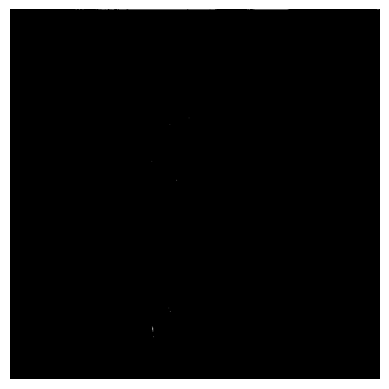

In [4]:
img_path = "loli.png"

# Load and preprocess the image
img = Image.open(img_path).resize(input_shape)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array[:, :, :3], axis=0) / 255.0

# Predict
pred = Unet_model.predict(img_array)

# Post-process prediction
pred = np.squeeze(pred, axis=0)  # Remove batch dimension
pred = np.argmax(pred, axis=-1)  # Remove channel dimension if it exists
pred = Image.fromarray(np.uint8(pred*255))  # Convert to grayscale image  
pred = pred.resize((img.width, img.height))  # Resize back to original dimensions

plt.imshow(pred, cmap='gray')
plt.axis('off')
plt.show()